In [39]:
# import libraries

# Data manipulation
import numpy as np
import pandas as pd
import re
import math
import datetime as dt

# Data visualisation
import seaborn as sns
from plotnine import *
import matplotlib.pyplot as plt
import matplotlib.axes as ax
%matplotlib inline

from mlxtend.frequent_patterns import apriori, fpgrowth
from mlxtend.frequent_patterns import association_rules 

import networkx as nx
from community import community_louvain

In [2]:
data = pd.read_excel('CompanyA-RetailCorpus-unprotected.xlsx')
data.head()

,Outlet,Order Date,Item,Item Name,Qty,Sales
0,WG,2018-11-10,FS0201823020000CF,KONTUR CHAIR,4,916.00
1,WG,2018-11-10,FS0200039020300DW,ROND DINING TABLE 150 X 80 X 74 CM,1,1167.55
2,WG,2018-11-10,FS0205112020000KF,LOIS DINING TABLE 135 CM - SOLID (1 FOLD X 24 MM),1,1399.00
3,WG,2018-12-08,BS0302778030100MA,3FT SINGLE BED WITH BEDSLATS,1,369.00
4,WG,2018-12-08,FS0308195030100MF,3FT SPINAL CARE MATTRESS,1,263.12


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34835 entries, 0 to 34834
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Outlet      34835 non-null  object        
 1   Order Date  34835 non-null  datetime64[ns]
 2   Item        34835 non-null  object        
 3   Item Name   34835 non-null  object        
 4   Qty         34835 non-null  int64         
 5   Sales       34835 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 1.6+ MB


In [4]:
def category(name):
    """splitting items into categories of furniture (places in house) from item names"""
    name = name.lower().split()
    dining = ['dining', 'fork', 'spoon', 'bowl', 'tray', 'teapot', 'bar', "chef's", 'microwave']
    bedroom = ['bed', 'daybed', 'bedside', 'bedslats', 'mattress', 'pocket-coil', 'wardrobe', 'sleep', 'pillow', 'dresser', 'dressing']
    office = ['office', 'writing', 'study', 'desk', 'secretary', 'computer', 'laptop']
    storage = ['shelf', 'shelve', 'shelves', 'bookcase', 'drawer', 'drawers', 'hanger', 'chest', 'divider', 'sideboard', 'shoe', 'shoes', 'cabinet']
    living = ['tv', 'sofa', 'cushion', 'seater', 'stool', 'table', 'chair', 'bench', 'console', 'ottoman']
    if np.setdiff1d(dining, name).size < len(dining): # at least 1 word matched
        return 'Dining Room'
    elif np.setdiff1d(bedroom, name).size < len(bedroom):
        return 'Bedroom'
    elif np.setdiff1d(office, name).size < len(office):
        return 'Home Office'
    elif np.setdiff1d(storage, name).size < len(storage):
        return 'Storage'
    elif np.setdiff1d(living, name).size < len(living): # rest of tables and chairs should belong here
        return 'Living Room'
    else: # display stands, covers, mirror, panel
        return 'Others'
    
data['Category'] = data['Item Name'].apply(category)

### mlxtend library: using Apriori (support, confidence, lift)
Aim: what are commonly bought together? what other things to recommend a buyer when an item is selected/purchased?

In [5]:
data = data.sort_values(by='Order Date', ascending=False) # latest to earliest
data.head(10)

,Outlet,Order Date,Item,Item Name,Qty,Sales,Category
22825,JCHIAT,2020-09-30,FS0301080031204RJ,KLASS CHEST OF DRAWERS 7,1,1393.15,Storage
18247,OESTOR,2020-09-30,FS0203808020000RK,PACIFIC DINING CHAIR WITH WOODEN SEAT BLOCK,4,984.20,Dining Room
22827,JCHIAT,2020-09-30,FS0502011050000KJ,SKOTT ADJUSTABLE WRITING TABLE,1,740.05,Home Office
22828,JCHIAT,2020-09-30,BS0305008030700NA,2 DOOR WARDROBE (C/W 1PC SHELF + 1PC ROD + 1 S...,1,1303.90,Bedroom
7549,TG,2020-09-30,BS0301995030201RW,3.5FT SUPER SINGLE BED WITH BEDSLATS,1,529.00,Bedroom
18470,OESTOR,2020-09-30,FS0301517031201JA,KAMP CHEST OF DRAWERS 5,1,729.00,Storage
32107,HEN,2020-09-30,FS0100011010000KJ,VALET TABLE,1,349.00,Living Room
13476,SP,2020-09-30,BS0301995030201RW,3.5FT SUPER SINGLE BED WITH BEDSLATS,2,1058.00,Bedroom
20669,KS,2020-09-30,FS0201016020000KJ,DUO BENCH-SCANTEAK FURNISHING,1,379.77,Others
20670,KS,2020-09-30,BS0500077050000CF,KONTUR BAR SET (1 TABLE + 2 CHAIRS),1,842.38,Dining Room


Since there is no user ID or exact timing of purchase, we shall group by `Outlet` and `Order Date` and count them as transactions. The assumption is that these are items that are (most likely) bought together.
<br> Example of a transaction/ 1 distinct label:

In [6]:
data[(data['Outlet'] == 'JCHIAT') & (pd.to_datetime(data['Order Date']) == '2020-09-30')]

,Outlet,Order Date,Item,Item Name,Qty,Sales,Category
22825,JCHIAT,2020-09-30,FS0301080031204RJ,KLASS CHEST OF DRAWERS 7,1,1393.15,Storage
22827,JCHIAT,2020-09-30,FS0502011050000KJ,SKOTT ADJUSTABLE WRITING TABLE,1,740.05,Home Office
22828,JCHIAT,2020-09-30,BS0305008030700NA,2 DOOR WARDROBE (C/W 1PC SHELF + 1PC ROD + 1 S...,1,1303.90,Bedroom
22826,JCHIAT,2020-09-30,BS0308110030300RK,BRIS 5FT BED WITH BEDSLATS,1,999.00,Bedroom


In [7]:
data[(data['Outlet'] == 'PLEBAR') & (pd.to_datetime(data['Order Date']) == '2018-09-01')]

,Outlet,Order Date,Item,Item Name,Qty,Sales,Category
15565,PLEBAR,2018-09-01,BS0302778030100MA,3FT SINGLE BED WITH BEDSLATS,4,1476.00,Bedroom
15570,PLEBAR,2018-09-01,FS0501702050000KJ,DISPLAY UNIT,1,816.05,Others
15571,PLEBAR,2018-09-01,FS0301101030000PT,KLAD CLOTHES HANGER,1,159.00,Storage
15569,PLEBAR,2018-09-01,FS0500032050000MA,LADA LAUNDRY CHEST,2,258.01,Storage
15568,PLEBAR,2018-09-01,FS0500027050500KJ,ATELIER DESK,1,599.00,Home Office
15567,PLEBAR,2018-09-01,FS0502011050000KJ,SKOTT ADJUSTABLE WRITING TABLE,1,599.00,Home Office
15566,PLEBAR,2018-09-01,BS0302010030200RJ,3.5FT STELLAN BED WITH BEDSLATS,2,1798.00,Bedroom
15572,PLEBAR,2018-09-01,FS0503058050401DW,KUBE TV BOARD 120X45X40CM\t\t\t\t\t,1,929.00,Living Room


<b>Aim</b> is to find items/furnitures which are commonly bought together, so that we can recommend customers other furnitures that might go well with their purchase or that might suit their preference. <br> To do this, since there are no user IDs or specific order time besides the date, we shall assume and group each Outlet-Order Date group as 1 specific label. This is to analyse the kind of furnitures that make up a single transaction basket typically. 

In [8]:
# labelling the groups
data['Label'] = data.groupby(['Outlet','Order Date']).grouper.group_info[0]
data.head()

,Outlet,Order Date,Item,Item Name,Qty,Sales,Category,Label
22825,JCHIAT,2020-09-30,FS0301080031204RJ,KLASS CHEST OF DRAWERS 7,1,1393.15,Storage,2393
18247,OESTOR,2020-09-30,FS0203808020000RK,PACIFIC DINING CHAIR WITH WOODEN SEAT BLOCK,4,984.20,Dining Room,3175
22827,JCHIAT,2020-09-30,FS0502011050000KJ,SKOTT ADJUSTABLE WRITING TABLE,1,740.05,Home Office,2393
22828,JCHIAT,2020-09-30,BS0305008030700NA,2 DOOR WARDROBE (C/W 1PC SHELF + 1PC ROD + 1 S...,1,1303.90,Bedroom,2393
7549,TG,2020-09-30,BS0301995030201RW,3.5FT SUPER SINGLE BED WITH BEDSLATS,1,529.00,Bedroom,5372


In [9]:
# example
data[data['Label'] == 0]
# here, dining table and dining chair are likely bought together

,Outlet,Order Date,Item,Item Name,Qty,Sales,Category,Label
33397,BALEST,2018-09-01,FS0500027050500KJ,ATELIER DESK,1,599.0,Home Office,0
33398,BALEST,2018-09-01,FS0500078050000CF,KONTUR BAR CHAIR,1,299.0,Dining Room,0
33399,BALEST,2018-09-01,FS0201814020000RJ,STELLAN DINING CHAIR,6,1614.0,Dining Room,0
33400,BALEST,2018-09-01,FS0202207020000RK,AVLANG DINING TABLE-165 X 90 X 74CM,1,999.0,Dining Room,0


In [10]:
# table of transactions with row: label, column: item
temp = data[['Item Name','Label']]
temp['Ones'] = 1
basket = temp.groupby(['Label', 'Item Name'])['Ones'].sum().unstack().fillna(0).reset_index().set_index('Label')
basket.shape 

<ipython-input-10-735fd994d770>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(6309, 612)

In [11]:
# when taking apriori, will encounter ValueError because there are values other than 0 and 1 in the basket df above
# i.e. bought item more than once for that label

for i in range(len(basket.columns)):
    cur_col = basket.columns[i]
    basket.loc[(basket[cur_col] > 1.0),cur_col] = 1 

In [12]:
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True) 
frequent_itemsets['distinct item qty'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets.sort_values(by='support', ascending=False, inplace=True)
frequent_itemsets

,support,itemsets,distinct item qty
79,0.113013,(KONTUR CHAIR),1
0,0.095102,((JAPAN)TRAY WITH LEG (WITH VARNISH)),1
81,0.090030,(KORTA OCCASIONAL SIDE TABLE),1
19,0.086226,(3FT SINGLE BED WITH BEDSLATS),1
104,0.070217,(OCCASIONAL STAND),1
...,...,...,...
159,0.010303,"(3.5FT BACK PEDIC MATTRESS, ENKEL 3.5FT BED WI...",2
88,0.010303,(LIGE DINING TABLE WITH 2 DRAWER),1
50,0.010303,(ENKEL TV STAND 4 DOORS\t\t\t\t\t\t\t\t\t\t\t\t),1
168,0.010144,"(KORTA OCCASIONAL SIDE TABLE, CASUAL SIDE TABLE)",2


In [13]:
frequent_itemsets[frequent_itemsets['distinct item qty'] > 1].head(5)

,support,itemsets,distinct item qty
183,0.019496,"(KORTA OCCASIONAL SIDE TABLE, KONTUR CHAIR)",2
155,0.017911,"((JAPAN)TRAY WITH LEG (WITH VARNISH), KONTUR C...",2
202,0.016484,"(VID CABINET W/ 3 SHELVES & DOORS, VID CABINET...",2
161,0.016167,"(3FT SINGLE BED WITH BEDSLATS, 3FT SPINAL CARE...",2
184,0.015692,"(KUBE BED SIDE TABLE, KONTUR CHAIR)",2


Observed that the support (item frequency amongst transactions) is very low for a vast majority of the items. 

#### Removing cold-start items - making dataset less sparse to find the frequent  itemsets.

In [14]:
# only keep items bought in at least 3 transactions
itemspop = data.groupby('Item Name')['Label'].size().sort_values(ascending=False)
itemspop = itemspop[itemspop > 2]
itemspop

Item Name
KONTUR CHAIR                                             834
(JAPAN)TRAY WITH LEG (WITH VARNISH)                      719
KORTA OCCASIONAL SIDE TABLE                              640
3FT SINGLE BED WITH BEDSLATS                             607
OCCASIONAL STAND                                         604
                                                        ... 
ND BOOKSHELF W-100CM                                       3
SLANK 120CM DINING TABLE (TAPERED LEG)                     3
SCREEN DIVIDER 170CM                                       3
SPINKEL SOFA 3-SEATER FRAME WITH WOODEN SLAT ONLY\t\t      3
3.5FT KOMFORT AIR MATTRESS-106X188X15CM                    3
Name: Label, Length: 412, dtype: int64

In [15]:
basket = basket.loc[:,itemspop.index]
basket
# 200 items bought in <3 transactions (transaction can have >1 Qty of that item) dropped

Item Name,KONTUR CHAIR,(JAPAN)TRAY WITH LEG (WITH VARNISH),KORTA OCCASIONAL SIDE TABLE,3FT SINGLE BED WITH BEDSLATS,OCCASIONAL STAND,KLAD CLOTHES HANGER,BOKA BOOKCASE C/W 4 SHELVES,APEN BOOKCASE 1 DRW,STAK NESTING TABLES,ISLAND DAYBED CW 1SEAT+2BACK (#1623-18)+1BOLSTER (#1623-19),...,BEDSIDE TABLE,321 SEATER CUSHION,5FT STELLAN TV SIDEBOARD,"5FT DIVAN BED #WHITE (H-11"")",FRISK TV SIDEBOARD 120CM,ND BOOKSHELF W-100CM,SLANK 120CM DINING TABLE (TAPERED LEG),SCREEN DIVIDER 170CM,SPINKEL SOFA 3-SEATER FRAME WITH WOODEN SLAT ONLY\t\t,3.5FT KOMFORT AIR MATTRESS-106X188X15CM
Label,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6304,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6305,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6306,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# dropping labels with less than 2 item purchases amongst the 412 items left
labelskeep = basket[basket.sum(axis=1) > 1].index
basket = basket[basket.sum(axis=1) > 1]
basket
# 1545 labels dropped

Item Name,KONTUR CHAIR,(JAPAN)TRAY WITH LEG (WITH VARNISH),KORTA OCCASIONAL SIDE TABLE,3FT SINGLE BED WITH BEDSLATS,OCCASIONAL STAND,KLAD CLOTHES HANGER,BOKA BOOKCASE C/W 4 SHELVES,APEN BOOKCASE 1 DRW,STAK NESTING TABLES,ISLAND DAYBED CW 1SEAT+2BACK (#1623-18)+1BOLSTER (#1623-19),...,BEDSIDE TABLE,321 SEATER CUSHION,5FT STELLAN TV SIDEBOARD,"5FT DIVAN BED #WHITE (H-11"")",FRISK TV SIDEBOARD 120CM,ND BOOKSHELF W-100CM,SLANK 120CM DINING TABLE (TAPERED LEG),SCREEN DIVIDER 170CM,SPINKEL SOFA 3-SEATER FRAME WITH WOODEN SLAT ONLY\t\t,3.5FT KOMFORT AIR MATTRESS-106X188X15CM
Label,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6303,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6304,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6305,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print('No. of labels: ',str(basket.shape[0]))
print('No. of items: ', str(basket.shape[1]))

No. of labels:  4764
No. of items:  412


In [18]:
# item sets that appear in AT LEAST 1% of the labels above
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True) 
frequent_itemsets['distinct item qty'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets.sort_values(by='support', ascending=False, inplace=True)
frequent_itemsets.head(10)

,support,itemsets,distinct item qty
0,0.143997,(KONTUR CHAIR),1
1,0.112091,((JAPAN)TRAY WITH LEG (WITH VARNISH)),1
2,0.110411,(KORTA OCCASIONAL SIDE TABLE),1
3,0.104954,(3FT SINGLE BED WITH BEDSLATS),1
4,0.083123,(OCCASIONAL STAND),1
5,0.083123,(KLAD CLOTHES HANGER),1
9,0.074517,(ISLAND DAYBED CW 1SEAT+2BACK (#1623-18)+1BOLS...,1
11,0.072628,(KUBE BED SIDE TABLE),1
8,0.070109,(STAK NESTING TABLES),1
14,0.069270,(STELLAN DINING CHAIR),1


In [19]:
# AT LEAST 1% confidence of item A consequently leading to item B
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold = 0.01) 
rules.drop(['leverage','conviction'], axis=1, inplace=True)
rules.sort_values(by='confidence', ascending=False, inplace=True)
rules['antecedents qty'] = rules['antecedents'].apply(lambda x: len(x))
rules['consequents qty'] = rules['consequents'].apply(lambda x: len(x))
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,antecedents qty,consequents qty
5,(VID CABINET ADJUSTABLE SHELF ONLY),(VID CABINET W/ 3 SHELVES & DOORS),0.023929,0.041142,0.021830,0.912281,22.174006,1,1
61,(IKON SOFA 1 SEATER WOODEN SEAT W/ CUSHION & C...,(IKON SOFA 3 SEATER WOODEN SEAT W/ CUSHION & C...,0.018682,0.066541,0.015113,0.808989,12.157800,1,1
93,(IKON SOFA 2 SEATER WOODEN SEAT W/ CUSHION & C...,(IKON SOFA 3 SEATER WOODEN SEAT W/ CUSHION & C...,0.019312,0.066541,0.013854,0.717391,10.781237,1,1
84,(SPINKEL SOFA 1 SEATER CW CUSHION & COVER #149...,(SPINKEL SOFA 3 SEATER CW CUSHION & COVER #149...,0.020151,0.057515,0.014064,0.697917,12.134580,1,1
11,(ROND DINING TABLE 135 X 80 X 74 CM),(KONTUR CHAIR),0.030227,0.143997,0.020361,0.673611,4.677964,1,1
64,(ROND DINING TABLE 150 X 80 X 74 CM),(KONTUR CHAIR),0.023090,0.143997,0.014694,0.636364,4.419295,1,1
57,(3FT BACK PEDIC MATTRESS),(3FT SINGLE BED WITH BEDSLATS),0.024559,0.104954,0.015113,0.615385,5.863385,1,1
145,(LOIS DINING TABLE 135 CM - SOLID (1 FOLD X 24...,(PLANK BENCH 100 X 40 X 45 CM (SOLID)),0.020571,0.048489,0.012175,0.591837,12.205672,1,1
33,(MONO DINING TABLE-150 X 75 X 72CM-SCANTEAK FU...,(MONO DINING CHAIR C/W SEAT CUSHION (#14009)),0.030437,0.041142,0.017632,0.579310,14.080788,1,1
132,(DUO BENCH-SCANTEAK FURNISHING),(MONO DINING TABLE-150 X 75 X 72CM-SCANTEAK FU...,0.022040,0.030437,0.012385,0.561905,18.461478,1,1


In [20]:
rules.shape

(270, 9)

### Observations:
- KONTUR CHAIR is the most frequently bought item, followed by (JAPAN)TRAY WITH LEG (WITH VARNISH) at 14% and 11% of the (Outlet, Date) transactions respectively
- <b>Confidence</b>: percentage of times consequent is purchased, given antecedent was purchased/ how much more likely Y occurs when X occurred
- Value is from 0 to 1 (1 being Y always purchased whenever X is purchased)
- Highest at 91.2% - when VID CABINET ADJUSTABLE SHELF ONLY is purchased, ~91% of the baskets will have VID CABINET W/ 3 SHELVES & DOORS too

- <b>Lift</b>: larger the lift, the greater the link between the 2 items, tells us how much our confidence has increased that Y will be purchased given that X was purchased
- Lift > 1 means presence of the antecedent increases the chances that that the consequent will occur in a transaction
- Lift < 1 means reduces the chances
- Lift = 1 means no differences to the chances; as good as guessing

In [21]:
ant = []
for i in range(len(rules)):
    items = list(rules['antecedents'].iloc[i])
    for item in items:
        ant.append(item)

In [22]:
pd.Series(ant).nunique()

65

In [23]:
rules['antecedents'] = rules['antecedents'].apply(lambda x: list(x))
rules['consequents'] = rules['consequents'].apply(lambda x: list(x))
rules.head(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,antecedents qty,consequents qty
5,[VID CABINET ADJUSTABLE SHELF ONLY],[VID CABINET W/ 3 SHELVES & DOORS],0.023929,0.041142,0.021830,0.912281,22.174006,1,1
61,[IKON SOFA 1 SEATER WOODEN SEAT W/ CUSHION & C...,[IKON SOFA 3 SEATER WOODEN SEAT W/ CUSHION & C...,0.018682,0.066541,0.015113,0.808989,12.157800,1,1
93,[IKON SOFA 2 SEATER WOODEN SEAT W/ CUSHION & C...,[IKON SOFA 3 SEATER WOODEN SEAT W/ CUSHION & C...,0.019312,0.066541,0.013854,0.717391,10.781237,1,1
84,[SPINKEL SOFA 1 SEATER CW CUSHION & COVER #149...,[SPINKEL SOFA 3 SEATER CW CUSHION & COVER #149...,0.020151,0.057515,0.014064,0.697917,12.134580,1,1
11,[ROND DINING TABLE 135 X 80 X 74 CM],[KONTUR CHAIR],0.030227,0.143997,0.020361,0.673611,4.677964,1,1


### Recommender using Apriori Algorithm + TF-IDF for those without/ insufficient consequents

In [24]:
import pdt_recommender
import importlib
importlib.reload(pdt_recommender)

<module 'pdt_recommender' from 'C:\\Users\\Aisyah\\Desktop\\Intern\\CompanyA\\pdt_recommender.py'>

In [25]:
def recommender(df, item):
    # other_ant = []
    recos = {}
    items = []
    for i in range(len(df)):
        # if df.iloc[i]['antecedents qty'] != 1:
            # if item in df.iloc[i]['antecedents']:
                # other_items = np.setdiff1d(df.iloc[i]['antecedents'], [item]) # bought together with antecedent
                # other_ant.append(other_items)
        if item in df.iloc[i]['antecedents']:
            consequents = df.iloc[i]['consequents']
            for c in consequents:
                recos[c] = df.iloc[i]['confidence']
                items.append(c)
    # if len(other_ant) != 0:
        # print('Other antecendent(s): {}'.format(other_ant))
    final_reco = {}
    final_reco['Associations'] = recos
    
    tfidf_rec = pdt_recommender.recommend(item)
    similar_items = list(tfidf_rec.keys())     
    remove = [item for item in similar_items if item in items] # overlapping (between association and similar) items
    for r in remove:
        tfidf_rec.pop(r)
    final_reco['Similar'] = tfidf_rec
    return final_reco

In [26]:
recommender(rules, 'VID CABINET ADJUSTABLE SHELF ONLY')

{'Associations': {'VID CABINET W/ 3 SHELVES & DOORS': 0.912280701754386},
 'Similar': {'VID CABINET W/ 3 SHELVES': 0.5796070573632242,
  'VID CABINET DOOR PANEL ONLY': 0.4995474885044706,
  'SKOTT ADJUSTABLE WRITING TABLE': 0.3297870849585286,
  'SHOE CABINET': 0.297736122076706,
  'ZATA CASUAL SIDE TABLE WITH ADJUSTABLE FEET': 0.2679692616715853,
  'SKAP CABINET (BUFFET)': 0.2318955232934265,
  'JEWEL CABINET ( LM )': 0.22241230564939596,
  '900MM SHELF (CJ)': 0.22035225010818815,
  'SHOE BENCH WITH 1 SHELF': 0.22006912710139234}}

### Evaluation: MAP@k & PMI

In [27]:
data

,Outlet,Order Date,Item,Item Name,Qty,Sales,Category,Label
22825,JCHIAT,2020-09-30,FS0301080031204RJ,KLASS CHEST OF DRAWERS 7,1,1393.15,Storage,2393
18247,OESTOR,2020-09-30,FS0203808020000RK,PACIFIC DINING CHAIR WITH WOODEN SEAT BLOCK,4,984.20,Dining Room,3175
22827,JCHIAT,2020-09-30,FS0502011050000KJ,SKOTT ADJUSTABLE WRITING TABLE,1,740.05,Home Office,2393
22828,JCHIAT,2020-09-30,BS0305008030700NA,2 DOOR WARDROBE (C/W 1PC SHELF + 1PC ROD + 1 S...,1,1303.90,Bedroom,2393
7549,TG,2020-09-30,BS0301995030201RW,3.5FT SUPER SINGLE BED WITH BEDSLATS,1,529.00,Bedroom,5372
...,...,...,...,...,...,...,...,...
16895,OESTOR,2018-09-01,FS0501062050101DW,LOUIS WRITING TABLE,1,359.00,Home Office,2618
23470,IS,2018-09-01,FF0500167050000RK,STADA DISPLAY STAND,1,169.00,Others,1344
69,WG,2018-09-01,BS0505122050701CJ,GD BOOKSHELF W-80CM,2,1575.10,Others,5717
70,WG,2018-09-01,FS0100011010000KJ,VALET TABLE,1,329.00,Living Room,5717


In [41]:
def ap_at_k(item):
    """Relevance: recommended item is within the same category as item"""
    item_category = data[['Item Name', 'Category']].drop_duplicates(keep='first').set_index('Item Name')
    to_match = item_category.loc[item][0]
    relevant = []
    items_reco = []
    items_reco += recommender(rules, item)['Associations']
    items_reco += recommender(rules, item)['Similar']
    items_reco = items_reco[:10]
    for reco in items_reco:
        reco_cat = item_category.loc[reco][0]
        if to_match == reco_cat:
            relevant.append(1)
        else:
            relevant.append(0)
#     print(relevant) 
    
    precision_sum = 0
    relevant_count = 0
    for i in range(len(relevant)):
        if relevant[i] == 1:
            relevant_count += 1
            precision_sum += relevant_count/(i+1)
    if relevant_count == 0:
        score = 0
    else:
        score = precision_sum/relevant_count
    return score

In [48]:
items = pd.Series(data['Item Name'].unique())

In [42]:
ap = 0
for i in range(len(items)):
    score = ap_at_k(items[i])
    ap += score

print('MAP@k across all items:\n')    
print(ap/len(items))

MAP@k across all items:

0.8499553903351467


In [44]:
data['Label'] = data.groupby(['Outlet','Order Date']).grouper.group_info[0]
data.drop_duplicates(subset=['Label','Item Name'], keep='first', inplace=True)
label_dict = {}
for i in range(len(data)):
    key = data.iloc[i]['Label']
    if key in label_dict:
        label_dict[key].append(data.iloc[i]['Item Name'])
    else:
        label_dict[key] = [data.iloc[i]['Item Name']]

In [31]:
def ap_at_k2(item):
    """Relevance: recommended item was indeed bought under (one of) the same (Outlet, Order Date) label as item"""
    labels = [x for x in data[data['Item Name'] == item]['Label'].unique()] # labels with the item purchased
    bought_tgt = [] # items in the same label/ transaction with item
    for l in labels:
        bought_tgt += label_dict[l]
    bought_tgt = set(bought_tgt)
    items_reco = []
    items_reco += recommender(rules, item)['Associations']
    items_reco += recommender(rules, item)['Similar']
    items_reco = items_reco[:10]
#     print(items_reco)
    
    precision_sum = 0
    relevant_count = 0
    for i in range(len(items_reco)):
        if items_reco[i] in bought_tgt:
            relevant_count += 1
            precision_sum += relevant_count/(i+1) 
    if relevant_count == 0:
        score = 0
    else:
        score = precision_sum/relevant_count
    return score

In [32]:
recommender(rules, 'KONTUR CHAIR')

{'Associations': {'KORTA OCCASIONAL SIDE TABLE': 0.1793002915451895,
  '(JAPAN)TRAY WITH LEG (WITH VARNISH)': 0.16472303206997085,
  'KUBE BED SIDE TABLE': 0.1443148688046647,
  'ROND DINING TABLE 135 X 80 X 74 CM': 0.141399416909621,
  'ISLAND DAYBED CW 1SEAT+2BACK (#1623-18)+1BOLSTER (#1623-19)': 0.13702623906705538,
  'STAK NESTING TABLES': 0.13556851311953352,
  'PLANK BENCH 100 X 40 X 45 CM (SOLID)': 0.13556851311953352,
  'KLAD CLOTHES HANGER': 0.1282798833819242,
  '3FT SINGLE BED WITH BEDSLATS': 0.12682215743440234,
  'RITA WRITING TABLE': 0.12536443148688048,
  'BENCH SET 1 WITH SUPPORT': 0.11807580174927114,
  'IKON SOFA 3 SEATER WOODEN SEAT W/ CUSHION & COVER #KB1710-06': 0.1107871720116618,
  'CASUAL SIDE TABLE': 0.10932944606413994,
  'ISLAND 2S CW 1SEAT+1BACK (#1623-18 LIGHT GREY)': 0.10932944606413994,
  'VALET TABLE': 0.10932944606413994,
  'BOKA BOOKCASE C/W 4 SHELVES': 0.10787172011661808,
  'OCCASIONAL STAND': 0.10641399416909621,
  'REKKI 5 LAYER OPEN SHELF': 0.1049

In [46]:
ap_at_k2('KONTUR CHAIR')

1.0

In [47]:
items = pd.Series(data['Item Name'].unique())

In [49]:
ap2 = 0
for i in range(len(items)):
    score = ap_at_k2(items[i])
    ap2 += score

print('MAP@k_2 across all items:\n')    
print(ap2/len(items))

Average AP@k_2 across all items:

0.5512940474543726


### Surprise metric: compare recommendations relative to the user’s historical item interaction. This measures “how surprising are these recommendations given what the user previously bought/clicked on”. 
- Through point-wise mutual information (PMI)
- PMI indicates how similar two items are based on the number of users who have purchased both items and each item separately (similar to measuring diversity based on users)
- PMI ranges from -1 to 1, where -1 indicates that the two items are never consumed together
- Lower PMI is, the more unexpected the recommendations are

![Image](pmi.png "PMI")

In [50]:
def mean_pmi(item):
    """i: item
    j: item being paired with"""
    labels = [x for x in data[data['Item Name'] == item]['Label'].unique()] # labels with the input item purchased
    bought_tgt = [] # items in the same label/ transaction with item
    for l in labels:
        bought_tgt += label_dict[l]
    items_reco = []
    items_reco += recommender(rules, item)['Associations']
    items_reco += recommender(rules, item)['Similar']
    items_reco = items_reco[:10]    
    
    num_labels = data['Label'].nunique()
    prob_i = data[data['Item Name'] == item]['Label'].nunique()/num_labels
    total_ij = 0
    
    for i in range(len(items_reco)):
        if items_reco[i] in bought_tgt:
            prob_j = data[data['Item Name'] == items_reco[i]]['Label'].nunique()/num_labels
            num_ij = bought_tgt.count(items_reco[i])
            prob_ij = num_ij/num_labels
            total_ij += (-math.log((prob_ij/(prob_i*prob_j)),2))/math.log(prob_ij,2)     
        # else add 0
    
    return total_ij/10

In [37]:
mean_pmi('KONTUR CHAIR')

0.21223882512461997

In [51]:
pmi = 0
for i in range(len(items)):
    score = mean_pmi(items[i])
    pmi += score

print('Average PMI across all items:\n')    
print(pmi/len(items))

Average PMI across all items:

0.11344482949258097


### mlxtend library: using FP-Growth
Aim: what are commonly bought together? what other things to recommend a buyer when an item is selected/purchased?

In [59]:
basket.head()

Item Name,KONTUR CHAIR,(JAPAN)TRAY WITH LEG (WITH VARNISH),KORTA OCCASIONAL SIDE TABLE,3FT SINGLE BED WITH BEDSLATS,OCCASIONAL STAND,KLAD CLOTHES HANGER,BOKA BOOKCASE C/W 4 SHELVES,APEN BOOKCASE 1 DRW,STAK NESTING TABLES,ISLAND DAYBED CW 1SEAT+2BACK (#1623-18)+1BOLSTER (#1623-19),...,BEDSIDE TABLE,321 SEATER CUSHION,5FT STELLAN TV SIDEBOARD,"5FT DIVAN BED #WHITE (H-11"")",FRISK TV SIDEBOARD 120CM,ND BOOKSHELF W-100CM,SLANK 120CM DINING TABLE (TAPERED LEG),SCREEN DIVIDER 170CM,SPINKEL SOFA 3-SEATER FRAME WITH WOODEN SLAT ONLY\t\t,3.5FT KOMFORT AIR MATTRESS-106X188X15CM
Label,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
# item sets that appear in AT LEAST 1% of the labels/ transactions above
frequent_itemsets2 = fpgrowth(basket, min_support=0.01, use_colnames=True) 
frequent_itemsets2['distinct item qty'] = frequent_itemsets2['itemsets'].apply(lambda x: len(x))
frequent_itemsets2.sort_values(by='support', ascending=False, inplace=True)
frequent_itemsets2.head(10)

,support,itemsets,distinct item qty
24,0.143997,(KONTUR CHAIR),1
96,0.112091,((JAPAN)TRAY WITH LEG (WITH VARNISH)),1
9,0.110411,(KORTA OCCASIONAL SIDE TABLE),1
70,0.104954,(3FT SINGLE BED WITH BEDSLATS),1
61,0.083123,(OCCASIONAL STAND),1
22,0.083123,(KLAD CLOTHES HANGER),1
19,0.074517,(ISLAND DAYBED CW 1SEAT+2BACK (#1623-18)+1BOLS...,1
46,0.072628,(KUBE BED SIDE TABLE),1
52,0.070109,(STAK NESTING TABLES),1
0,0.069270,(STELLAN DINING CHAIR),1


In [61]:
# AT LEAST 1% confidence of item A consequently leading to item B
rules = association_rules(frequent_itemsets2, metric="confidence", min_threshold = 0.01) 
rules.drop(['leverage','conviction'], axis=1, inplace=True)
rules.sort_values(by='confidence', ascending=False, inplace=True)
rules['antecedents qty'] = rules['antecedents'].apply(lambda x: len(x))
rules['consequents qty'] = rules['consequents'].apply(lambda x: len(x))
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,antecedents qty,consequents qty
5,(VID CABINET ADJUSTABLE SHELF ONLY),(VID CABINET W/ 3 SHELVES & DOORS),0.023929,0.041142,0.021830,0.912281,22.174006,1,1
57,(IKON SOFA 1 SEATER WOODEN SEAT W/ CUSHION & C...,(IKON SOFA 3 SEATER WOODEN SEAT W/ CUSHION & C...,0.018682,0.066541,0.015113,0.808989,12.157800,1,1
91,(IKON SOFA 2 SEATER WOODEN SEAT W/ CUSHION & C...,(IKON SOFA 3 SEATER WOODEN SEAT W/ CUSHION & C...,0.019312,0.066541,0.013854,0.717391,10.781237,1,1
86,(SPINKEL SOFA 1 SEATER CW CUSHION & COVER #149...,(SPINKEL SOFA 3 SEATER CW CUSHION & COVER #149...,0.020151,0.057515,0.014064,0.697917,12.134580,1,1
11,(ROND DINING TABLE 135 X 80 X 74 CM),(KONTUR CHAIR),0.030227,0.143997,0.020361,0.673611,4.677964,1,1
66,(ROND DINING TABLE 150 X 80 X 74 CM),(KONTUR CHAIR),0.023090,0.143997,0.014694,0.636364,4.419295,1,1
59,(3FT BACK PEDIC MATTRESS),(3FT SINGLE BED WITH BEDSLATS),0.024559,0.104954,0.015113,0.615385,5.863385,1,1
143,(LOIS DINING TABLE 135 CM - SOLID (1 FOLD X 24...,(PLANK BENCH 100 X 40 X 45 CM (SOLID)),0.020571,0.048489,0.012175,0.591837,12.205672,1,1
31,(MONO DINING TABLE-150 X 75 X 72CM-SCANTEAK FU...,(MONO DINING CHAIR C/W SEAT CUSHION (#14009)),0.030437,0.041142,0.017632,0.579310,14.080788,1,1
134,(DUO BENCH-SCANTEAK FURNISHING),(MONO DINING TABLE-150 X 75 X 72CM-SCANTEAK FU...,0.022040,0.030437,0.012385,0.561905,18.461478,1,1


In [62]:
rules.shape

(270, 9)

### Observations:
- Results are exactly the same as with Apriori Algorithm (using the same mlxtend package)
- FP-Growth is just a drop-in replacement for Apriori; comes with the same function arguments and return arguments

In [72]:
%timeit -n 10 -r 10 apriori(basket, min_support=0.01)
# %timeit -n 100 -r 10 apriori(basket, min_support=0.01) # 10 runs, 100 loops each

861 ms ± 51.7 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [73]:
%timeit -n 10 -r 10 apriori(basket, min_support=0.01, low_memory=True)

93.4 ms ± 5.57 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [74]:
%timeit -n 10 -r 10 fpgrowth(basket, min_support=0.01)

111 ms ± 7.2 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


As seen above, when the Apriori algorithm is not set to low_memory, the computation time takes up almost 8 times that of FP-Growth.
- Apriori: multiple scans of the database is required to check support count of each item and itemsets
- If database is huge, it will cost a significant amount of space and computing power
- FP-Growth algorithm is created to overcome this shortfall; faster computation time, lower space
- FP-Growth: only scans the database twice and uses a tree structure (FP-tree) to store all the information

### Graph algorithm to recommend items in its 'community'
Node:Item Name
<br> Edge: 'weight' property which determines the strength of the relationship between the nodes - taken into account when calculating modularity (quantifies quality of assignment of nodes to respective communities)

In [75]:
# cleaning: filtering out infrequent items/labels 
data2 = data.set_index('Item Name').loc[itemspop.index].reset_index() # drop items in <3 transactions
data2 = data2.set_index('Label').loc[labelskeep].reset_index() # drop labels with <2 items
data2.head()

,Label,Item Name,Outlet,Order Date,Item,Qty,Sales,Category
0,0,STELLAN DINING CHAIR,BALEST,2018-09-01,FS0201814020000RJ,6,1614.0,Dining Room
1,0,ATELIER DESK,BALEST,2018-09-01,FS0500027050500KJ,1,599.0,Home Office
2,0,AVLANG DINING TABLE-165 X 90 X 74CM,BALEST,2018-09-01,FS0202207020000RK,1,999.0,Dining Room
3,0,KONTUR BAR CHAIR,BALEST,2018-09-01,FS0500078050000CF,1,299.0,Dining Room
4,1,CASUAL SIDE TABLE,BALEST,2018-09-02,FS0102206010600MA,2,398.0,Living Room


In [76]:
data2 = data2.drop_duplicates(subset=['Label','Item Name'], keep='first')
purchase = data2.pivot(index = 'Label', columns='Item Name', values='Qty').fillna(0).astype('int')
# binary purchase matrix (indicate if a customer has purchased an item or not)
purchase_binary = purchase.copy()
purchase_binary[purchase_binary != 0] = 1
purchase_binary.head()

Item Name,(JAPAN)TRAY WITH LEG (WITH VARNISH),(JPN) IKON 2S WOODEN SEAT CUSHION & COVER#GAZELLE04-W/O LOGO,1 DOOR WARDROBE WITH 3 PCS SHELVES (W/ DOOR),1 DR BODY 450MM (W/O DOOR) (CJ),1 DR BODY 450MM (W/O DOOR) (CJ) - NEW VERSION,1 SEATER COVER,1 SEATER COVER ONLY #14905 SMOKE (NEWSOFT)(1S+1B)(JPN),1 SEATER CUSHION,140CM FISKE SIDEBOARD WITH 4 DRAWERS + 2 DOORS,2 DOOR WARDROBE (C/W 1PC SHELF + 1PC ROD + 1 SET DRAWER),...,VILA 1-SEATER FRAME WITH CUSHION & COVER #KB1203-7 GREY,VILA 2-SEATER FRAME WITH CUSHION & COVER #13030 BULLET,VILA 2-SEATER FRAME WITH CUSHION & COVER #KB1203-7 GREY,VILA 3-SEATER FRAME WITH CUSHION & COVER #13030 BULLET,VILA 3-SEATER FRAME WITH CUSHION & COVER #KB1203-7 GREY,VINNA WRITING TABLE,WD BOOKSHELF W-100CM,WD BOOKSHELF W-80CM,WRITING TABLE,ZATA CASUAL SIDE TABLE
Label,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
# initialise for item interactions (bought together)
table = np.zeros([len(itemspop),len(itemspop)])

# num times each item pair has been purchased
# print('Counting how many times each pair of items has been purchased...')
for i in range(len(itemspop)):
    for j in range(len(itemspop)):
        if i != j:
            df_ij = purchase_binary.iloc[:,[i,j]] # temporary df with only i and j products as columns
            sum_ij = df_ij.sum(axis=1)
            pairs_ij = len(sum_ij[sum_ij == 2]) # num labels where both products were purchased 
            table[i,j] = pairs_ij
            table[j,i] = pairs_ij

table

array([[ 0.,  2.,  7., ...,  8., 13., 62.],
       [ 2.,  0.,  0., ...,  0.,  1.,  1.],
       [ 7.,  0.,  0., ...,  0.,  3.,  3.],
       ...,
       [ 8.,  0.,  0., ...,  0.,  2.,  6.],
       [13.,  1.,  3., ...,  2.,  0.,  5.],
       [62.,  1.,  3., ...,  6.,  5.,  0.]])

In [78]:
table.shape

(412, 412)

In [79]:
# num of times each item was bought in pairs
times_purchased = table.sum(axis = 1)

In [80]:
# final weighted matrix of item interactions
# print('Building weighted item matrix...')
items_weighted = np.zeros([len(itemspop),len(itemspop)])
for i in range(len(itemspop)):
    for j in range(len(itemspop)):
        if (times_purchased[i] + times_purchased[j]) != 0: # cannot divide with zero so filter out those
            items_weighted[i,j] = (table[i,j])/(times_purchased[i]+times_purchased[j])

c:\users\aisyah\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
c:\users\aisyah\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.


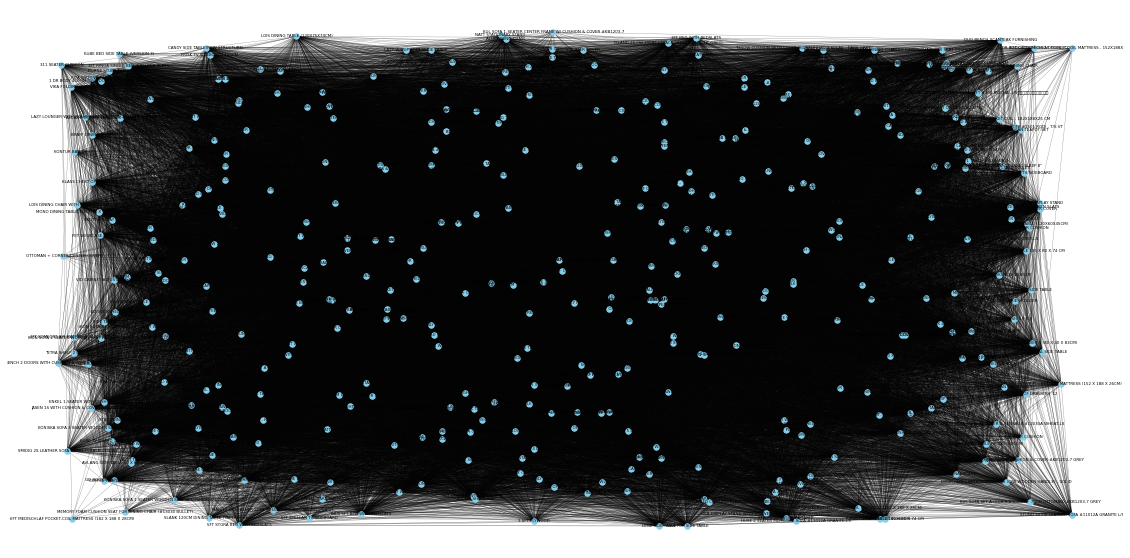

In [81]:
# can't see much - too many items
# create Graph object using weighted item matrix as adjacency matrix
graph = nx.from_numpy_matrix(items_weighted)
pos = nx.random_layout(graph) # position nodes uniformly at random
labels = {}
for idx, node in enumerate(graph.nodes()):
    labels[node] = purchase_binary.columns[idx]

plt.figure(figsize=(20,10))
nx.draw_networkx_nodes(graph, pos , node_color="skyblue", node_size=30)
nx.draw_networkx_edges(graph, pos,  edge_color='k', width= 0.3, alpha= 0.5)
nx.draw_networkx_labels(graph, pos, labels, font_size=4)
plt.axis('off')
plt.show()

In [92]:
partition = community_louvain.best_partition(graph, resolution=0.9) # community detection within graph, resolution changes size of the communities, default: 1
values = list(partition.values())

In [93]:
print('Number of communities:', len(np.unique(values)))

Number of communities: 10


In [94]:
item_communities = pd.DataFrame(list(purchase_binary.columns), columns = ['Item Name'])
item_communities['community_id'] = values

In [95]:
item_communities.groupby('community_id').size()

community_id
0    77
1    94
2    44
3    12
4    38
5    31
6     6
7    21
8    19
9    70
dtype: int64

In [96]:
item_communities[item_communities['community_id'] == 3]

,Item Name,community_id
34,311 SEATER COVER,3
35,311 SEATER CUSHION,3
76,6FT MEDISCHLAF POCKET-COIL MATTRESS (182 X 188...,3
129,DESKTOP POWER TRACK 50CM CW 2 MLT SOCKET #ME17...,3
201,JASEN 1S WITH CUSHION & COVER #142 ATEJA LIGHT...,3
202,JASEN 2S WITH CUSHION & COVER #142 ATEJA LIGHT...,3
203,JASEN 4S WITH CUSHION & COVER #142 ATEJA LIGHT...,3
205,JASEN COFFEE TABLE (SOLID TOP),3
206,JASEN SIDE TABLE ( SOLID TOP),3
219,KONTUR BAR CHAIR,3
